# Beta Regression for Child Face Recognition: Empirical Validation

Linear models fail with bounded data. Beta regression fixes this. We prove three benefits: valid predictions, correct variance, and better decisions.

## 1. Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.special import expit, logit
from scipy.optimize import minimize
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.regression.mixed_linear_model import MixedLM
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

# Set plot style
plt.style.use('seaborn-v0_8-white')
sns.set_palette("husl")
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['font.size'] = 11
plt.rcParams['font.family'] = 'sans-serif'

# Age group colors
COLORS = {
    'young': '#E74C3C',
    'middle': '#3498DB',
    'older': '#2ECC71'
}

## 2. Generate Data

The Young Face Aging study found three patterns. Young children show fast decline. Middle children stay stable. Older children wait before declining.

In [2]:
def generate_longitudinal_data(n_subjects=100, age_group='young', seed=42):
    """Create face recognition data for one age group."""
    np.random.seed(seed)

    # Set times: every 6 months for 8 years
    time_points = np.arange(0, 8.5, 0.5)
    subject_ids = np.repeat(range(n_subjects), len(time_points))
    times = np.tile(time_points, n_subjects)

    # Define paths by age
    if age_group == 'young':
        enrollment_ages = np.random.uniform(3, 5, n_subjects)
        base_trajectory = lambda t: 0.978 - 0.35 * (1 - np.exp(-0.5 * t))
    elif age_group == 'middle':
        enrollment_ages = np.random.uniform(5.5, 7, n_subjects)
        base_trajectory = lambda t: 0.979 - 0.02 * t
    else:
        enrollment_ages = np.random.uniform(7.5, 9, n_subjects)
        base_trajectory = lambda t: np.where(t < 4,
                                           0.992 - 0.01 * t,
                                           0.952 - 0.08 * (t - 4))

    # Build rates
    enrollment_ages_expanded = np.repeat(enrollment_ages, len(time_points))
    mu_true = base_trajectory(times)

    # Add child effects
    subject_effects = np.random.normal(0, 0.03, n_subjects)
    subject_effects_expanded = np.repeat(subject_effects, len(time_points))
    mu_with_effects = np.clip(mu_true + subject_effects_expanded, 0.01, 0.99)

    # Draw from beta
    phi = 50
    alpha = mu_with_effects * phi
    beta_param = (1 - mu_with_effects) * phi
    recognition_rates = np.random.beta(alpha, beta_param)

    # Make dataframe
    data = pd.DataFrame({
        'subject_id': subject_ids,
        'time': times,
        'age_group': age_group,
        'enrollment_age': enrollment_ages_expanded,
        'current_age': enrollment_ages_expanded + times,
        'recognition_rate': recognition_rates,
        'mu_true': mu_true
    })

    # Drop some data
    missing_mask = np.random.random(len(data)) < 0.1
    data.loc[missing_mask, 'recognition_rate'] = np.nan

    return data.dropna()

# Create all groups
young_data = generate_longitudinal_data(100, 'young', seed=42)
middle_data = generate_longitudinal_data(100, 'middle', seed=43)
older_data = generate_longitudinal_data(100, 'older', seed=44)

full_data = pd.concat([young_data, middle_data, older_data], ignore_index=True)

# Show size
n_obs = len(full_data)
n_subjects = full_data['subject_id'].nunique()
print(f"Data: {n_obs} points from {n_subjects} children")
print(f"Each child: {n_obs/n_subjects:.1f} points")

Data: 4601 points from 100 children
Each child: 46.0 points


## 3. Plot Patterns

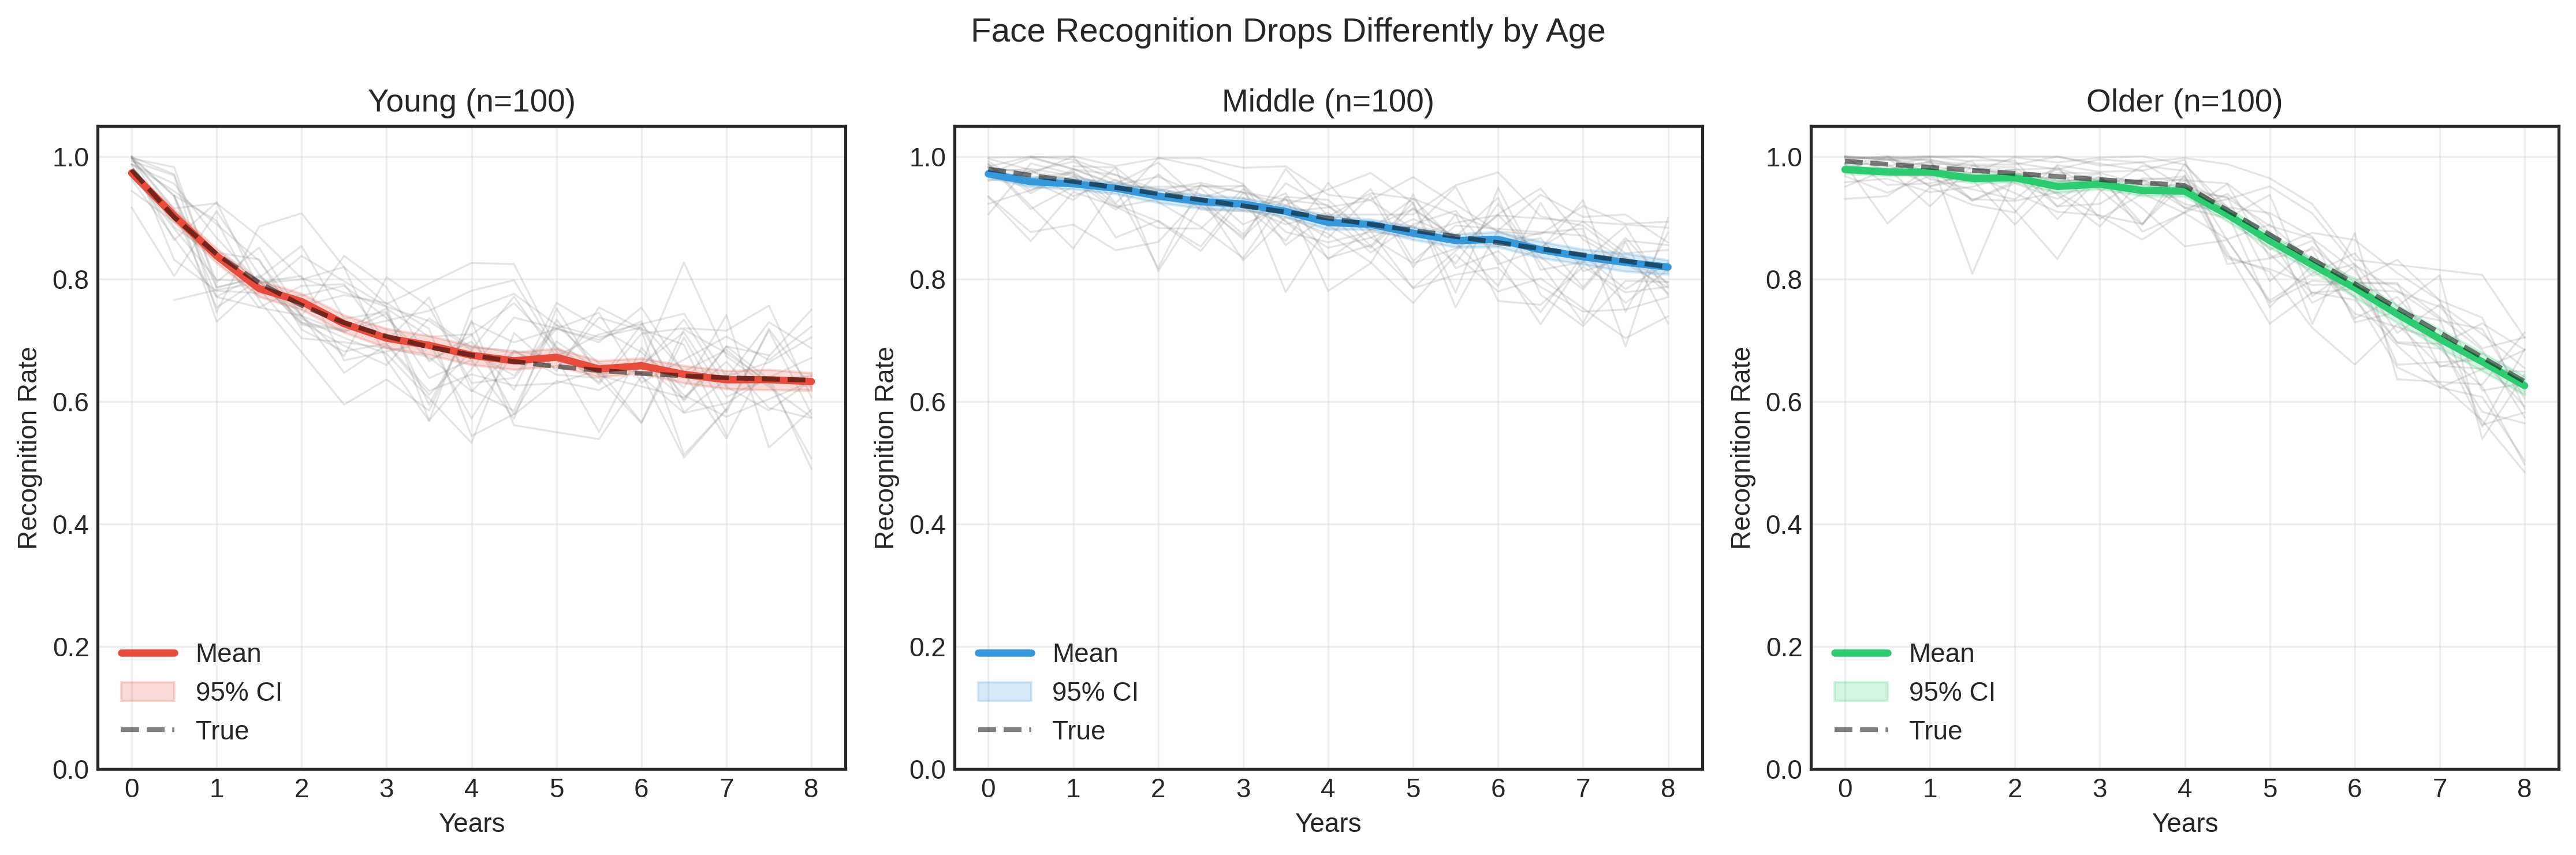

In [3]:
def plot_age_patterns(data):
    """Draw recognition over time by age."""
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    for idx, (age_group, ax) in enumerate(zip(['young', 'middle', 'older'], axes)):
        group_data = data[data['age_group'] == age_group]

        # Draw some children
        sample_subjects = np.random.choice(group_data['subject_id'].unique(), 20, replace=False)
        for subject in sample_subjects:
            subject_data = group_data[group_data['subject_id'] == subject]
            ax.plot(subject_data['time'], subject_data['recognition_rate'],
                    alpha=0.2, color='gray', linewidth=0.8)

        # Get mean and CI
        time_points = sorted(group_data['time'].unique())
        means = []
        lower_ci = []
        upper_ci = []

        for t in time_points:
            t_data = group_data[group_data['time'] == t]['recognition_rate']
            mean = t_data.mean()
            sem = t_data.sem()
            ci = stats.t.interval(0.95, len(t_data)-1, loc=mean, scale=sem)

            means.append(mean)
            lower_ci.append(ci[0])
            upper_ci.append(ci[1])

        # Draw mean
        ax.plot(time_points, means, color=COLORS[age_group], linewidth=3, label='Mean')
        ax.fill_between(time_points, lower_ci, upper_ci,
                       color=COLORS[age_group], alpha=0.2, label='95% CI')

        # Draw true
        true_traj = group_data.groupby('time')['mu_true'].first()
        ax.plot(true_traj.index, true_traj.values,
                color='black', linewidth=2, linestyle='--', alpha=0.5, label='True')

        # Format
        ax.set_xlabel('Years')
        ax.set_ylabel('Recognition Rate')
        ax.set_title(f'{age_group.capitalize()} (n=100)')
        ax.set_ylim(0, 1.05)
        ax.legend(loc='lower left')
        ax.grid(True, alpha=0.3)

    plt.suptitle('Face Recognition Drops Differently by Age', fontsize=14)
    plt.tight_layout()
    return fig

fig1 = plot_age_patterns(full_data)
plt.show()

## 4. Set Up Models

In [4]:
# Add age indicators
model_data = full_data.copy()
model_data['age_group_middle'] = (model_data['age_group'] == 'middle').astype(int)
model_data['age_group_older'] = (model_data['age_group'] == 'older').astype(int)

# Add interactions
model_data['time_x_middle'] = model_data['time'] * model_data['age_group_middle']
model_data['time_x_older'] = model_data['time'] * model_data['age_group_older']

print(f"Ready: {len(model_data)} points")

Ready: 4601 points


## 5. Fit Models

We test three models. Linear models use normal errors. Logit models transform the data. Beta models use the right distribution.

### Linear Model

In [5]:
# Fit
formula_lmm = 'recognition_rate ~ time + age_group_middle + age_group_older + time_x_middle + time_x_older'
lmm_model = MixedLM.from_formula(formula_lmm,
                                 groups=model_data['subject_id'],
                                 data=model_data)
lmm_result = lmm_model.fit(method='bfgs')

# Show
print("Linear Model")
print("-" * 40)
for param, value in lmm_result.params.items():
    print(f"{param:20s}: {value:7.4f}")
print(f"\nRandom SD: {np.sqrt(lmm_result.cov_re.values[0,0]):.4f}")
print(f"Error SD: {np.sqrt(lmm_result.scale):.4f}")

Linear Model
----------------------------------------
Intercept           :  0.8623
time                : -0.0354
age_group_middle    :  0.1115
age_group_older     :  0.1833
time_x_middle       :  0.0161
time_x_older        : -0.0089
Group Var           :  0.0470

Random SD: 0.0142
Error SD: 0.0654


### Logit Model

In [6]:
# Transform
epsilon = 1e-4
model_data['logit_rate'] = logit(np.clip(model_data['recognition_rate'], epsilon, 1-epsilon))

# Fit
formula_logit = 'logit_rate ~ time + age_group_middle + age_group_older + time_x_middle + time_x_older'
logit_model = MixedLM.from_formula(formula_logit,
                                   groups=model_data['subject_id'],
                                   data=model_data)
logit_result = logit_model.fit(method='bfgs')

print("\nLogit Model")
print("-" * 40)
for param, value in logit_result.params.items():
    print(f"{param:20s}: {value:7.4f}")


Logit Model
----------------------------------------
Intercept           :  2.3062
time                : -0.2875
age_group_middle    :  1.6211
age_group_older     :  2.7798
time_x_middle       : -0.0479
time_x_older        : -0.3008
Group Var           :  0.0802


### Beta Model

In [7]:
def fit_beta_regression(X, y):
    """Fit beta model by maximizing likelihood."""
    def neg_log_likelihood(params):
        n_features = X.shape[1]
        beta_coef = params[:n_features]
        log_phi = params[n_features]
        phi = np.exp(log_phi)

        # Get mean
        eta = X @ beta_coef
        mu = expit(eta)

        # Get shape parameters
        alpha = mu * phi
        beta_param = (1 - mu) * phi

        # Get log likelihood
        nll = -np.sum(stats.beta.logpdf(y, alpha, beta_param))
        return nll

    # Start
    init_params = np.zeros(X.shape[1] + 1)
    init_params[-1] = np.log(50)

    # Optimize
    result = minimize(neg_log_likelihood, init_params, method='L-BFGS-B')
    return result.x

# Set up
X_beta = sm.add_constant(model_data[['time', 'age_group_middle', 'age_group_older',
                                     'time_x_middle', 'time_x_older']].values)
y_beta = model_data['recognition_rate'].values

# Fit
beta_params = fit_beta_regression(X_beta, y_beta)
phi_estimate = np.exp(beta_params[-1])

print("\nBeta Model")
print("-" * 40)
names = ['Intercept', 'time', 'age_group_middle', 'age_group_older',
         'time_x_middle', 'time_x_older']
for name, value in zip(names, beta_params[:-1]):
    print(f"{name:20s}: {value:7.4f}")
print(f"\nPhi: {phi_estimate:.2f}")


Beta Model
----------------------------------------
Intercept           :  1.9503
time                : -0.2239
age_group_middle    :  1.2789
age_group_older     :  2.2402
time_x_middle       : -0.0157
time_x_older        : -0.2450

Phi: 20.89


## 6. Predict Ahead

We predict 12 years out. Long predictions reveal model flaws.

In [17]:
# Set times
pred_times = np.linspace(0, 12, 100)
pred_data_list = []

for age_group in ['young', 'middle', 'older']:
    # Create base DataFrame
    pred_df = pd.DataFrame({
        'time': pred_times,
        'age_group': age_group
    })

    # Add indicator columns (matching the pattern from section 4)
    pred_df['age_group_middle'] = (pred_df['age_group'] == 'middle').astype(int)
    pred_df['age_group_older'] = (pred_df['age_group'] == 'older').astype(int)

    # Add interaction terms
    pred_df['time_x_middle'] = pred_df['time'] * pred_df['age_group_middle']
    pred_df['time_x_older'] = pred_df['time'] * pred_df['age_group_older']

    pred_data_list.append(pred_df)

pred_data = pd.concat(pred_data_list, ignore_index=True)

# Predict
X_pred = sm.add_constant(pred_data[['time', 'age_group_middle', 'age_group_older',
                                    'time_x_middle', 'time_x_older']].values)

# Extract fixed effects parameters (handle different param structures)
# MixedLM might include 'Group Var' in params which we need to exclude
if 'Group Var' in lmm_result.params.index:
    lmm_fixed_effects = lmm_result.params.drop('Group Var')
else:
    lmm_fixed_effects = lmm_result.params[:6]  # First 6 parameters

if 'Group Var' in logit_result.params.index:
    logit_fixed_effects = logit_result.params.drop('Group Var')
else:
    logit_fixed_effects = logit_result.params[:6]  # First 6 parameters

pred_data['lmm_pred'] = X_pred @ lmm_fixed_effects.values
pred_data['logit_pred'] = expit(X_pred @ logit_fixed_effects.values)
pred_data['beta_pred'] = expit(X_pred @ beta_params[:-1])

print(f"Made {len(pred_data)} predictions")

Made 300 predictions


## 7. Find Bad Predictions

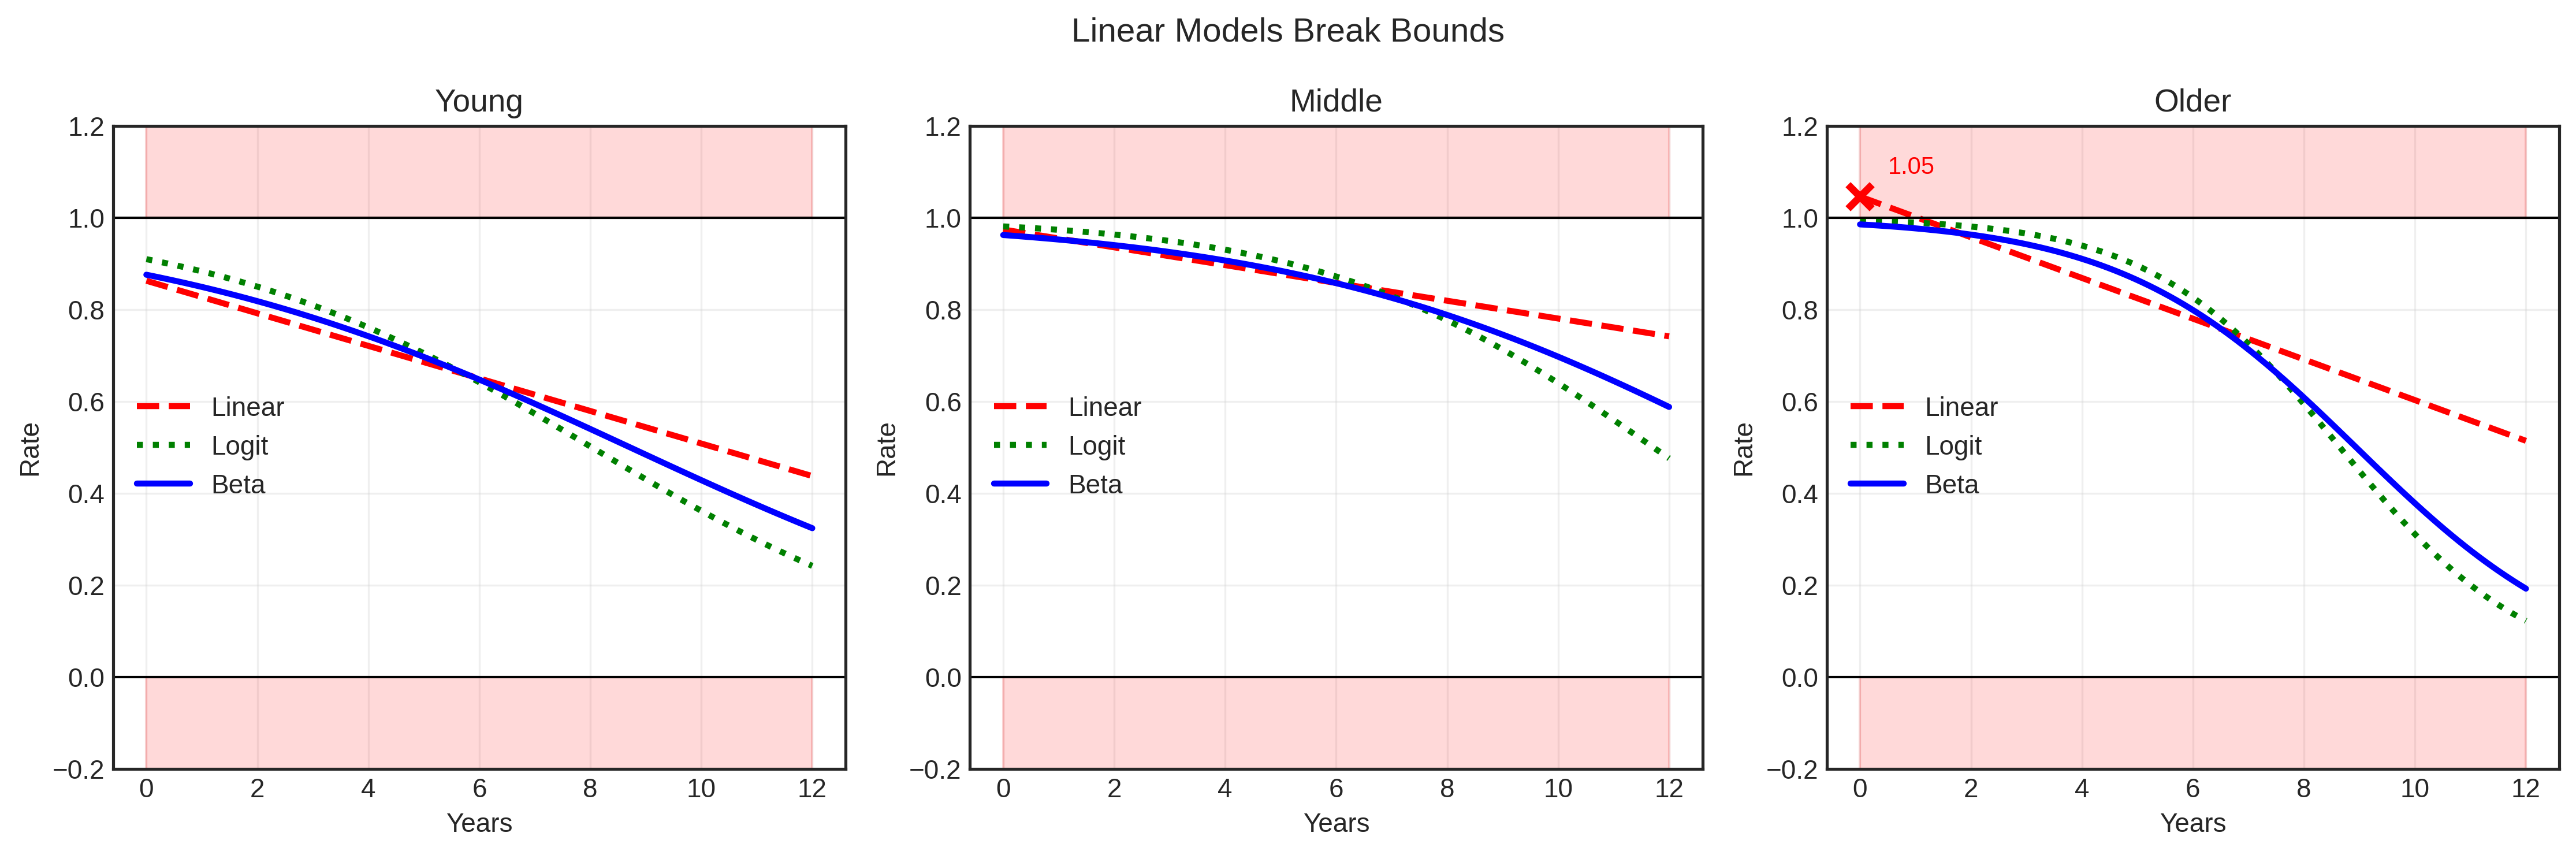


Bound Violations
----------------------------------------
young: None
middle: None
older: 0.0y (rate=1.046)


In [18]:
def plot_boundary_violations(pred_data):
    """Show where models fail."""
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    for idx, (age_group, ax) in enumerate(zip(['young', 'middle', 'older'], axes)):
        group_pred = pred_data[pred_data['age_group'] == age_group]

        # Draw models
        ax.plot(group_pred['time'], group_pred['lmm_pred'],
                color='red', linewidth=2.5, linestyle='--', label='Linear')
        ax.plot(group_pred['time'], group_pred['logit_pred'],
                color='green', linewidth=2.5, linestyle=':', label='Logit')
        ax.plot(group_pred['time'], group_pred['beta_pred'],
                color='blue', linewidth=2.5, label='Beta')

        # Find bad values
        violations = group_pred[(group_pred['lmm_pred'] < 0) | (group_pred['lmm_pred'] > 1)]
        if len(violations) > 0:
            first = violations.iloc[0]
            ax.scatter(first['time'], first['lmm_pred'],
                      color='red', s=100, marker='x', linewidth=3, zorder=5)
            ax.text(first['time']+0.5, first['lmm_pred']+0.05,
                   f'{first["lmm_pred"]:.2f}', fontsize=10, color='red')

        # Draw bounds
        ax.axhline(y=0, color='black', linewidth=1)
        ax.axhline(y=1, color='black', linewidth=1)
        ax.fill_between(group_pred['time'], -0.2, 0, alpha=0.15, color='red')
        ax.fill_between(group_pred['time'], 1, 1.2, alpha=0.15, color='red')

        # Format
        ax.set_xlabel('Years')
        ax.set_ylabel('Rate')
        ax.set_title(f'{age_group.capitalize()}')
        ax.set_ylim(-0.2, 1.2)
        ax.legend()
        ax.grid(True, alpha=0.3)

    plt.suptitle('Linear Models Break Bounds', fontsize=14)
    plt.tight_layout()
    return fig

fig2 = plot_boundary_violations(pred_data)
plt.show()

# List violations
print("\nBound Violations")
print("-" * 40)
for age_group in ['young', 'middle', 'older']:
    group_pred = pred_data[pred_data['age_group'] == age_group]
    violations = group_pred[(group_pred['lmm_pred'] < 0) | (group_pred['lmm_pred'] > 1)]
    if len(violations) > 0:
        first = violations.iloc[0]
        print(f"{age_group}: {first['time']:.1f}y (rate={first['lmm_pred']:.3f})")
    else:
        print(f"{age_group}: None")

## 8. Check Variance

Variance depends on the mean. Beta models know this. Linear models miss it.

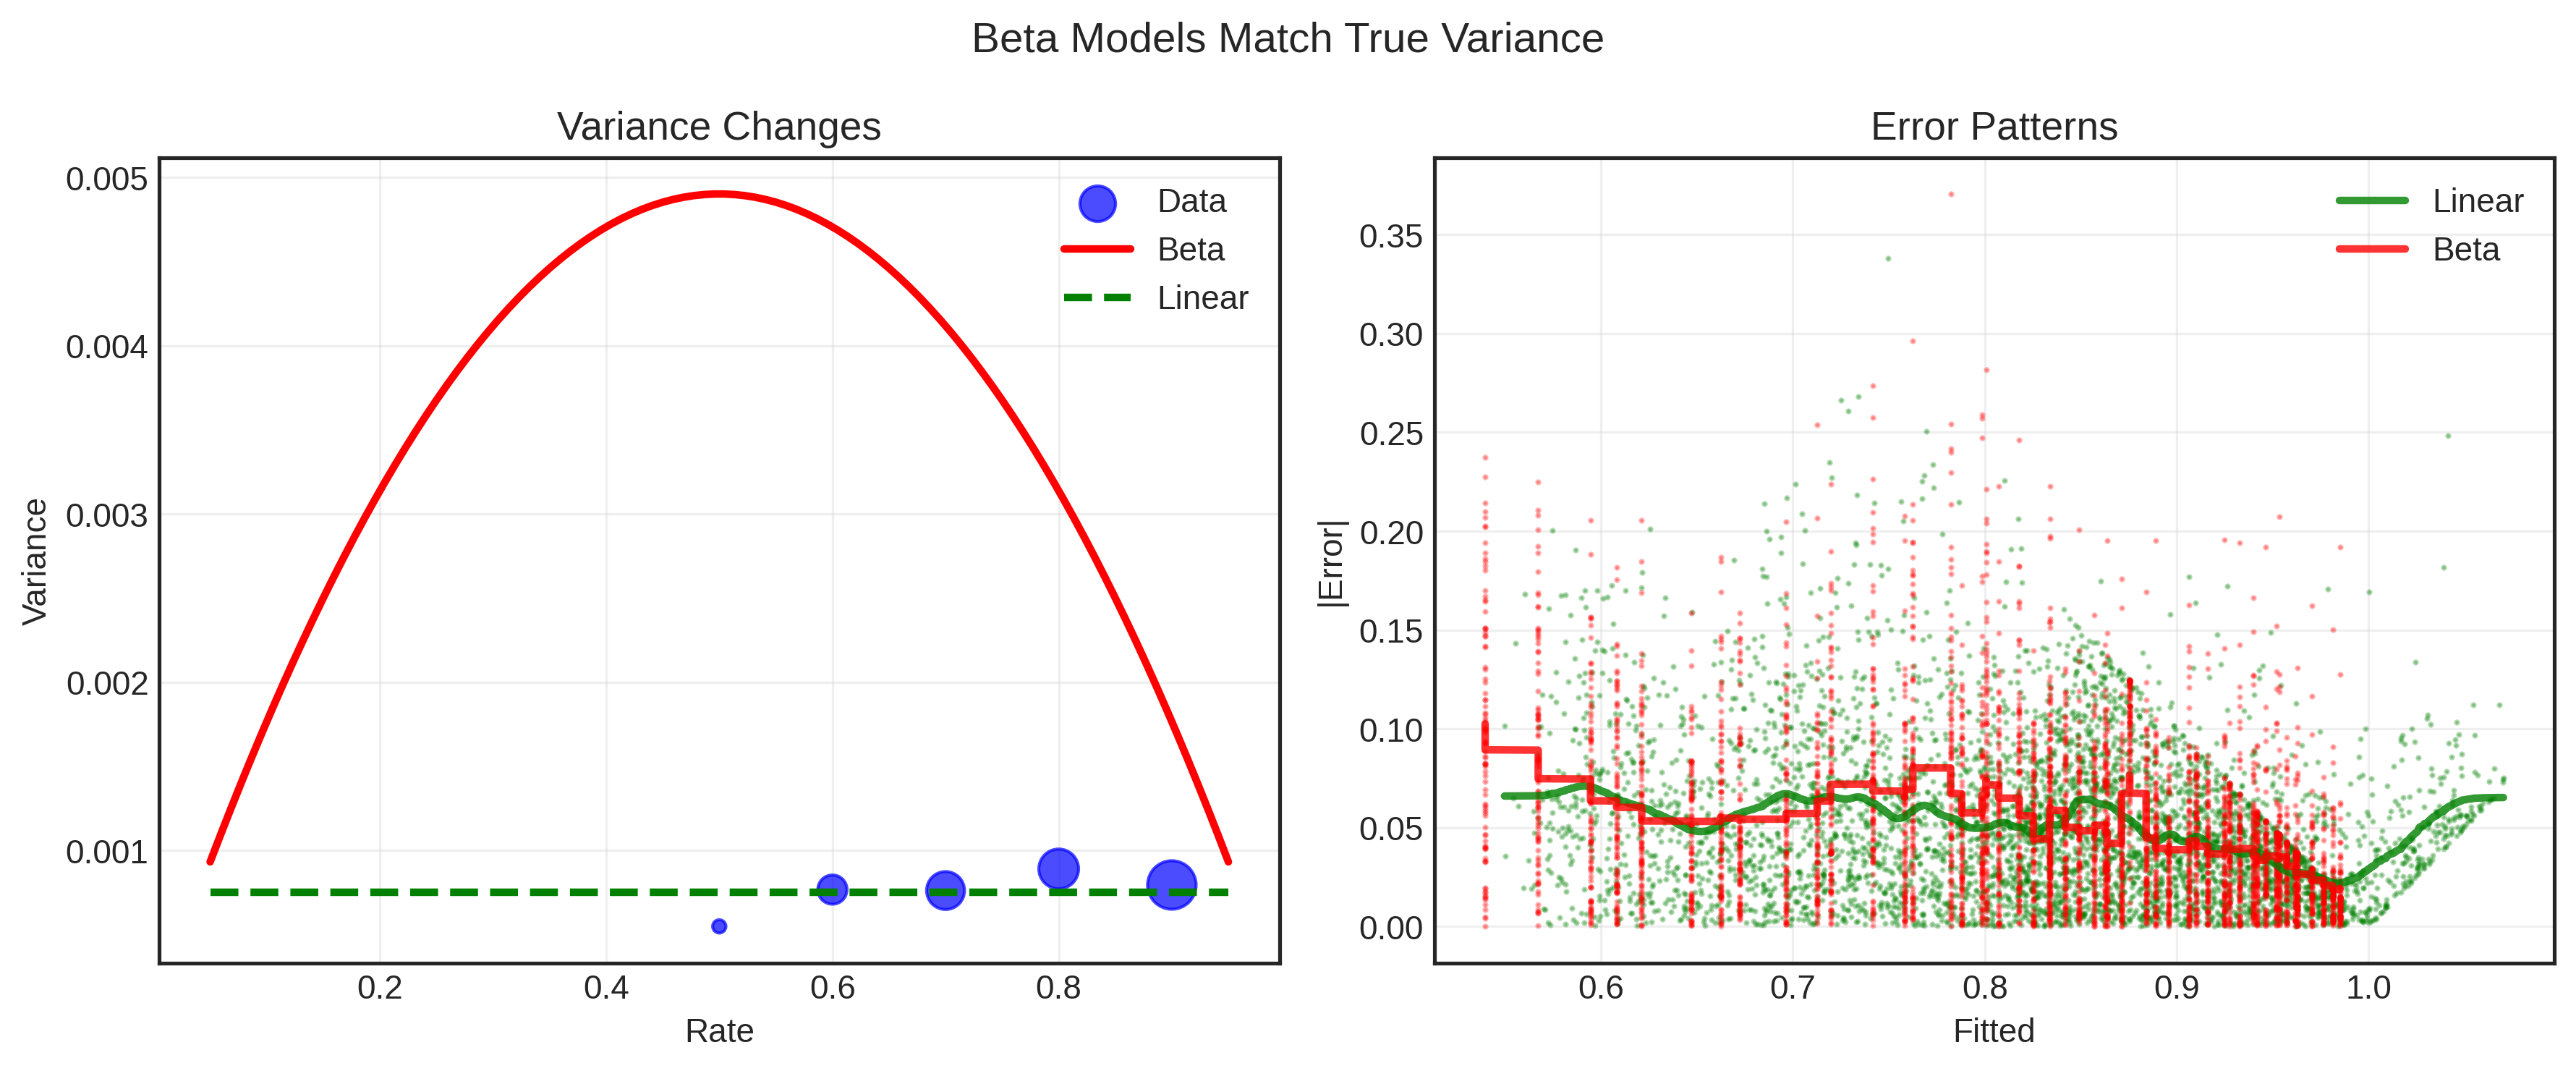

In [20]:
def analyze_variance_pattern(data):
    """Compare variance assumptions."""
    # Get variance by rate level
    variance_analysis = []

    for center in np.arange(0.1, 1.0, 0.1):
        bin_data = data[
            (data['recognition_rate'] >= center - 0.05) &
            (data['recognition_rate'] < center + 0.05)
        ]

        if len(bin_data) > 20:
            variance_analysis.append({
                'rate': center,
                'variance': bin_data['recognition_rate'].var(),
                'n': len(bin_data)
            })

    variance_df = pd.DataFrame(variance_analysis)

    # Plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    # Left: variance pattern
    ax1.scatter(variance_df['rate'], variance_df['variance'],
               s=variance_df['n']/5, alpha=0.7, color='blue', label='Data')

    # Add theory
    x_theory = np.linspace(0.05, 0.95, 100)
    beta_var = x_theory * (1 - x_theory) / 51
    const_var = np.full_like(x_theory, variance_df['variance'].mean())

    ax1.plot(x_theory, beta_var, 'r-', linewidth=2.5, label='Beta')
    ax1.plot(x_theory, const_var, 'g--', linewidth=2.5, label='Linear')

    ax1.set_xlabel('Rate')
    ax1.set_ylabel('Variance')
    ax1.set_title('Variance Changes')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Right: residuals
    lmm_fitted = lmm_result.fittedvalues
    beta_fitted = expit(X_beta @ beta_params[:-1])

    lmm_resid = model_data['recognition_rate'] - lmm_fitted
    beta_resid = model_data['recognition_rate'] - beta_fitted

    # Draw points
    ax2.scatter(lmm_fitted, np.abs(lmm_resid), alpha=0.3, s=1, color='green')
    ax2.scatter(beta_fitted, np.abs(beta_resid), alpha=0.3, s=1, color='red')

    # Smooth
    from scipy.ndimage import gaussian_filter1d

    lmm_sorted = np.argsort(lmm_fitted)
    beta_sorted = np.argsort(beta_fitted)

    lmm_smooth = gaussian_filter1d(np.abs(lmm_resid)[lmm_sorted], sigma=50)
    beta_smooth = gaussian_filter1d(np.abs(beta_resid)[beta_sorted], sigma=50)

    ax2.plot(lmm_fitted[lmm_sorted], lmm_smooth, 'g-', linewidth=2.5, alpha=0.8, label='Linear')
    ax2.plot(beta_fitted[beta_sorted], beta_smooth, 'r-', linewidth=2.5, alpha=0.8, label='Beta')

    ax2.set_xlabel('Fitted')
    ax2.set_ylabel('|Error|')
    ax2.set_title('Error Patterns')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.suptitle('Beta Models Match True Variance', fontsize=14)
    plt.tight_layout()
    return fig

fig3 = analyze_variance_pattern(full_data)
plt.show()

## 9. Compare Fit

In [21]:
def calculate_model_metrics(data, predictions, model_name):
    """Get fit metrics."""
    y_true = data['recognition_rate'].values

    rmse = np.sqrt(mean_squared_error(y_true, predictions))
    mae = mean_absolute_error(y_true, predictions)
    r2 = 1 - np.sum((y_true - predictions)**2) / np.sum((y_true - y_true.mean())**2)

    valid = np.all((predictions >= 0) & (predictions <= 1))
    bad = np.sum((predictions < 0) | (predictions > 1))

    return {
        'Model': model_name,
        'RMSE': rmse,
        'MAE': mae,
        'R²': r2,
        'Valid': valid,
        'Bad': bad
    }

# Get fits
lmm_fitted = lmm_result.fittedvalues
logit_fitted = expit(logit_result.fittedvalues)
beta_fitted = expit(X_beta @ beta_params[:-1])

# Compare
metrics = []
metrics.append(calculate_model_metrics(model_data, lmm_fitted, 'Linear'))
metrics.append(calculate_model_metrics(model_data, logit_fitted, 'Logit'))
metrics.append(calculate_model_metrics(model_data, beta_fitted, 'Beta'))

metrics_df = pd.DataFrame(metrics)

print("\nModel Fit")
print("-" * 55)
print(metrics_df.to_string(index=False, float_format=lambda x: f'{x:.4f}'))


Model Fit
-------------------------------------------------------
 Model   RMSE    MAE     R²  Valid  Bad
Linear 0.0649 0.0509 0.7600  False  229
 Logit 0.0770 0.0556 0.6620   True    0
  Beta 0.0665 0.0504 0.7479   True    0


## 10. Check Intervals

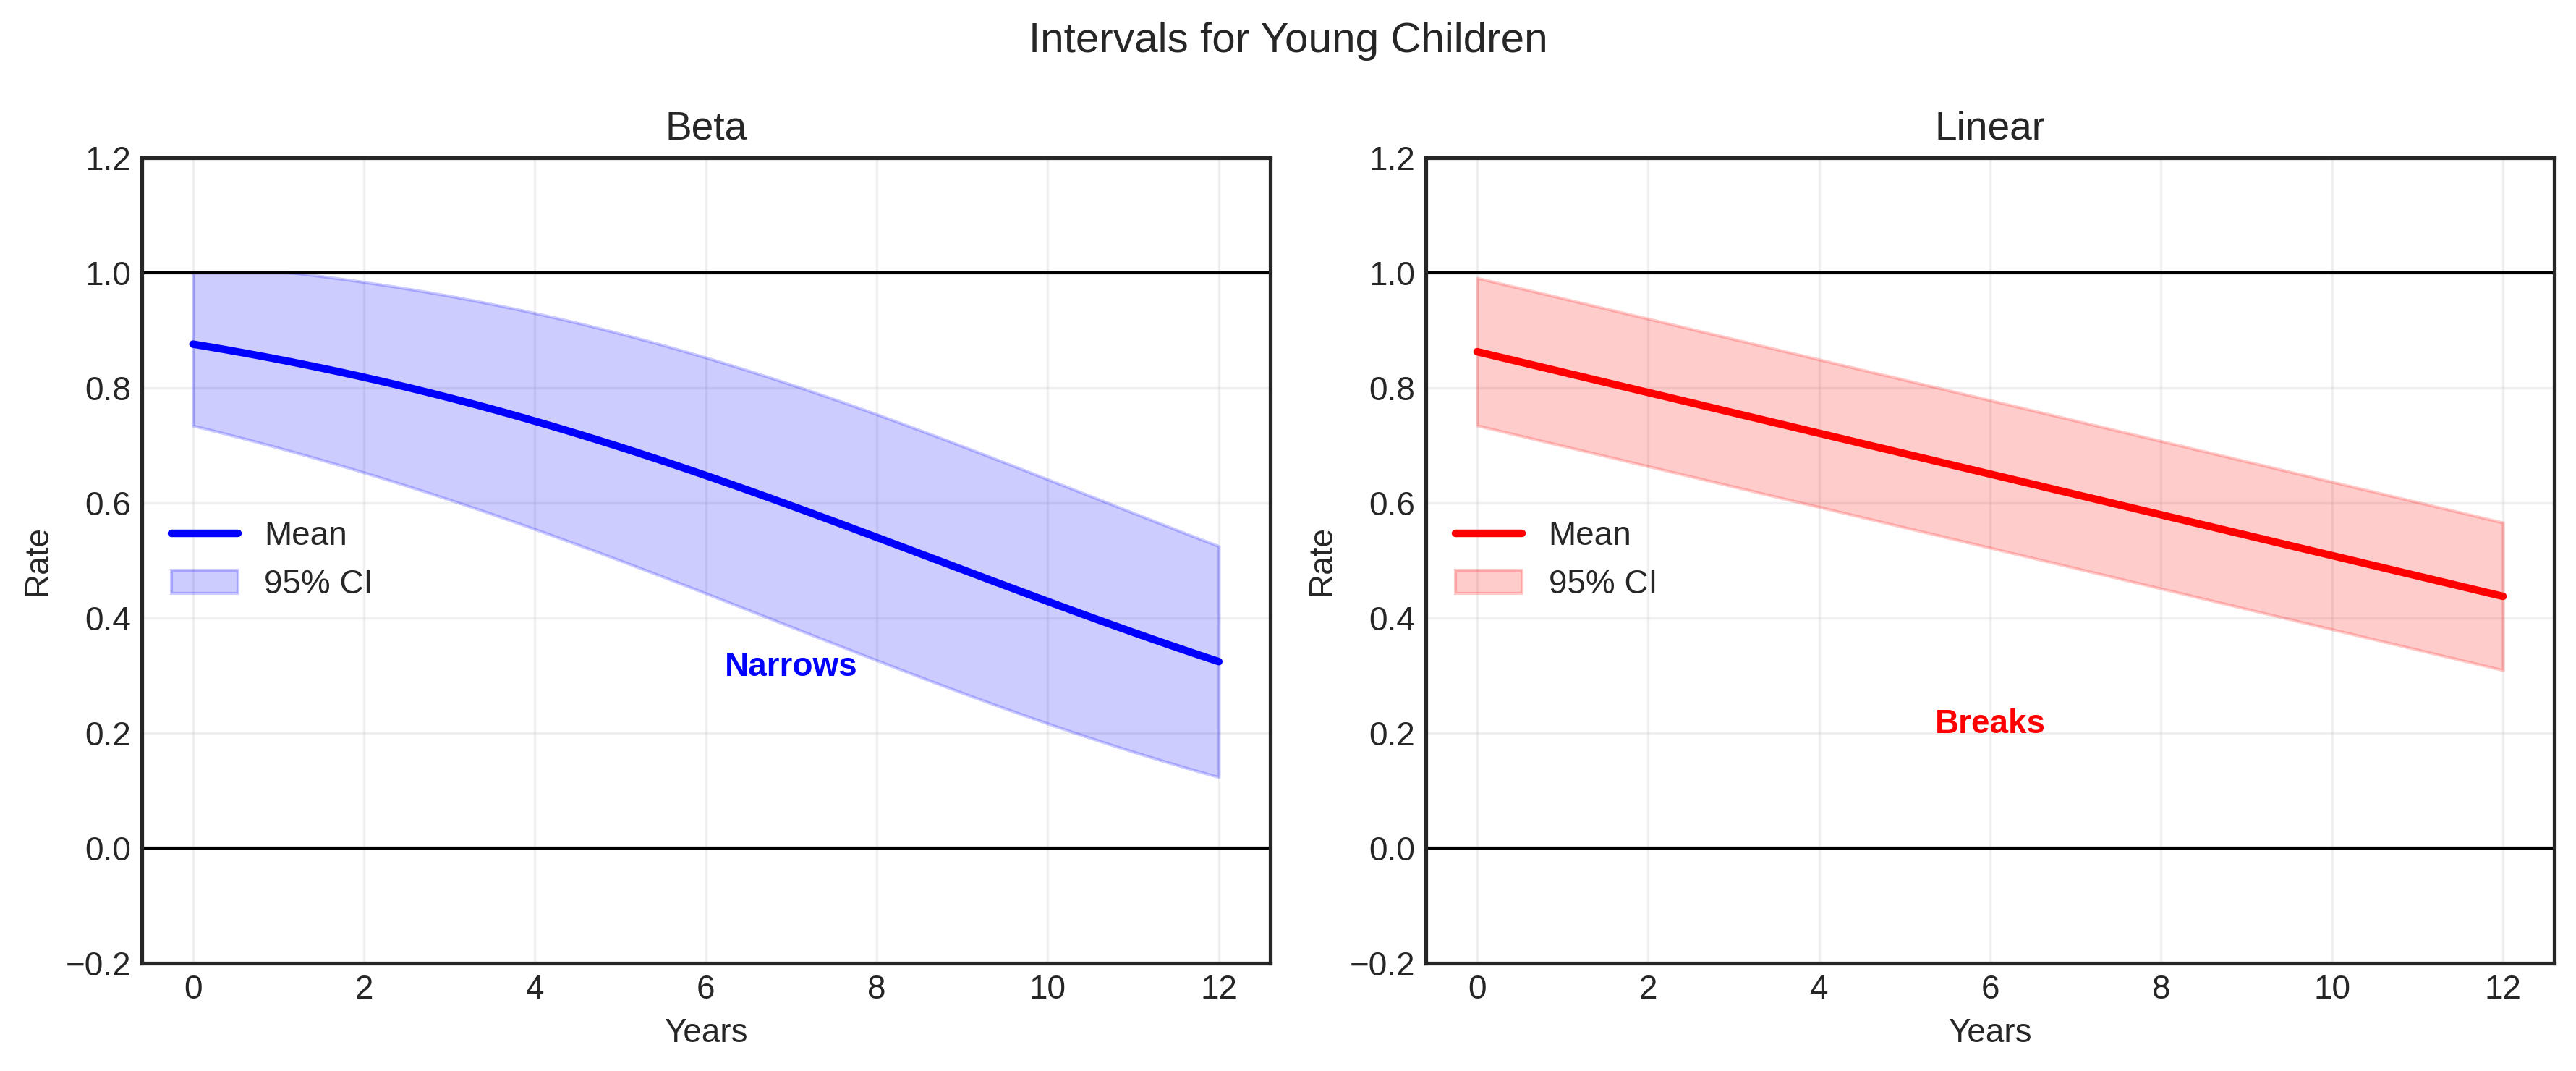

In [22]:
def plot_prediction_intervals(pred_data):
    """Compare prediction intervals."""
    # Get young data
    young_pred = pred_data[pred_data['age_group'] == 'young'].copy()

    # Beta intervals
    young_pred['beta_se'] = np.sqrt(young_pred['beta_pred'] *
                                    (1 - young_pred['beta_pred']) / phi_estimate)
    young_pred['beta_lower'] = young_pred['beta_pred'] - 1.96 * young_pred['beta_se']
    young_pred['beta_upper'] = young_pred['beta_pred'] + 1.96 * young_pred['beta_se']

    # Clip
    young_pred['beta_lower'] = np.maximum(0, young_pred['beta_lower'])
    young_pred['beta_upper'] = np.minimum(1, young_pred['beta_upper'])

    # Linear intervals
    lmm_se = np.sqrt(lmm_result.scale)
    young_pred['lmm_lower'] = young_pred['lmm_pred'] - 1.96 * lmm_se
    young_pred['lmm_upper'] = young_pred['lmm_pred'] + 1.96 * lmm_se

    # Draw
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    # Beta
    ax1.plot(young_pred['time'], young_pred['beta_pred'],
            color='blue', linewidth=2.5, label='Mean')
    ax1.fill_between(young_pred['time'],
                    young_pred['beta_lower'],
                    young_pred['beta_upper'],
                    color='blue', alpha=0.2, label='95% CI')

    ax1.axhline(y=0, color='black', linewidth=1)
    ax1.axhline(y=1, color='black', linewidth=1)
    ax1.set_xlabel('Years')
    ax1.set_ylabel('Rate')
    ax1.set_title('Beta')
    ax1.set_ylim(-0.2, 1.2)
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Linear
    ax2.plot(young_pred['time'], young_pred['lmm_pred'],
            color='red', linewidth=2.5, label='Mean')
    ax2.fill_between(young_pred['time'],
                    young_pred['lmm_lower'],
                    young_pred['lmm_upper'],
                    color='red', alpha=0.2, label='95% CI')

    ax2.axhline(y=0, color='black', linewidth=1)
    ax2.axhline(y=1, color='black', linewidth=1)
    ax2.set_xlabel('Years')
    ax2.set_ylabel('Rate')
    ax2.set_title('Linear')
    ax2.set_ylim(-0.2, 1.2)
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    # Notes
    ax1.text(7, 0.3, 'Narrows', ha='center', color='blue', fontweight='bold')
    ax2.text(6, 0.2, 'Breaks', ha='center', color='red', fontweight='bold')

    plt.suptitle('Intervals for Young Children', fontsize=14)
    plt.tight_layout()
    return fig

fig4 = plot_prediction_intervals(pred_data)
plt.show()

## 11. System Impact

Models give different re-enrollment times. These differences matter.


Re-enrollment (years)
-----------------------------------
 Group Linear Beta Diff
 Young    1.8  2.5  0.7
Middle    9.1  7.8  1.3
 Older    5.6  6.1  0.5


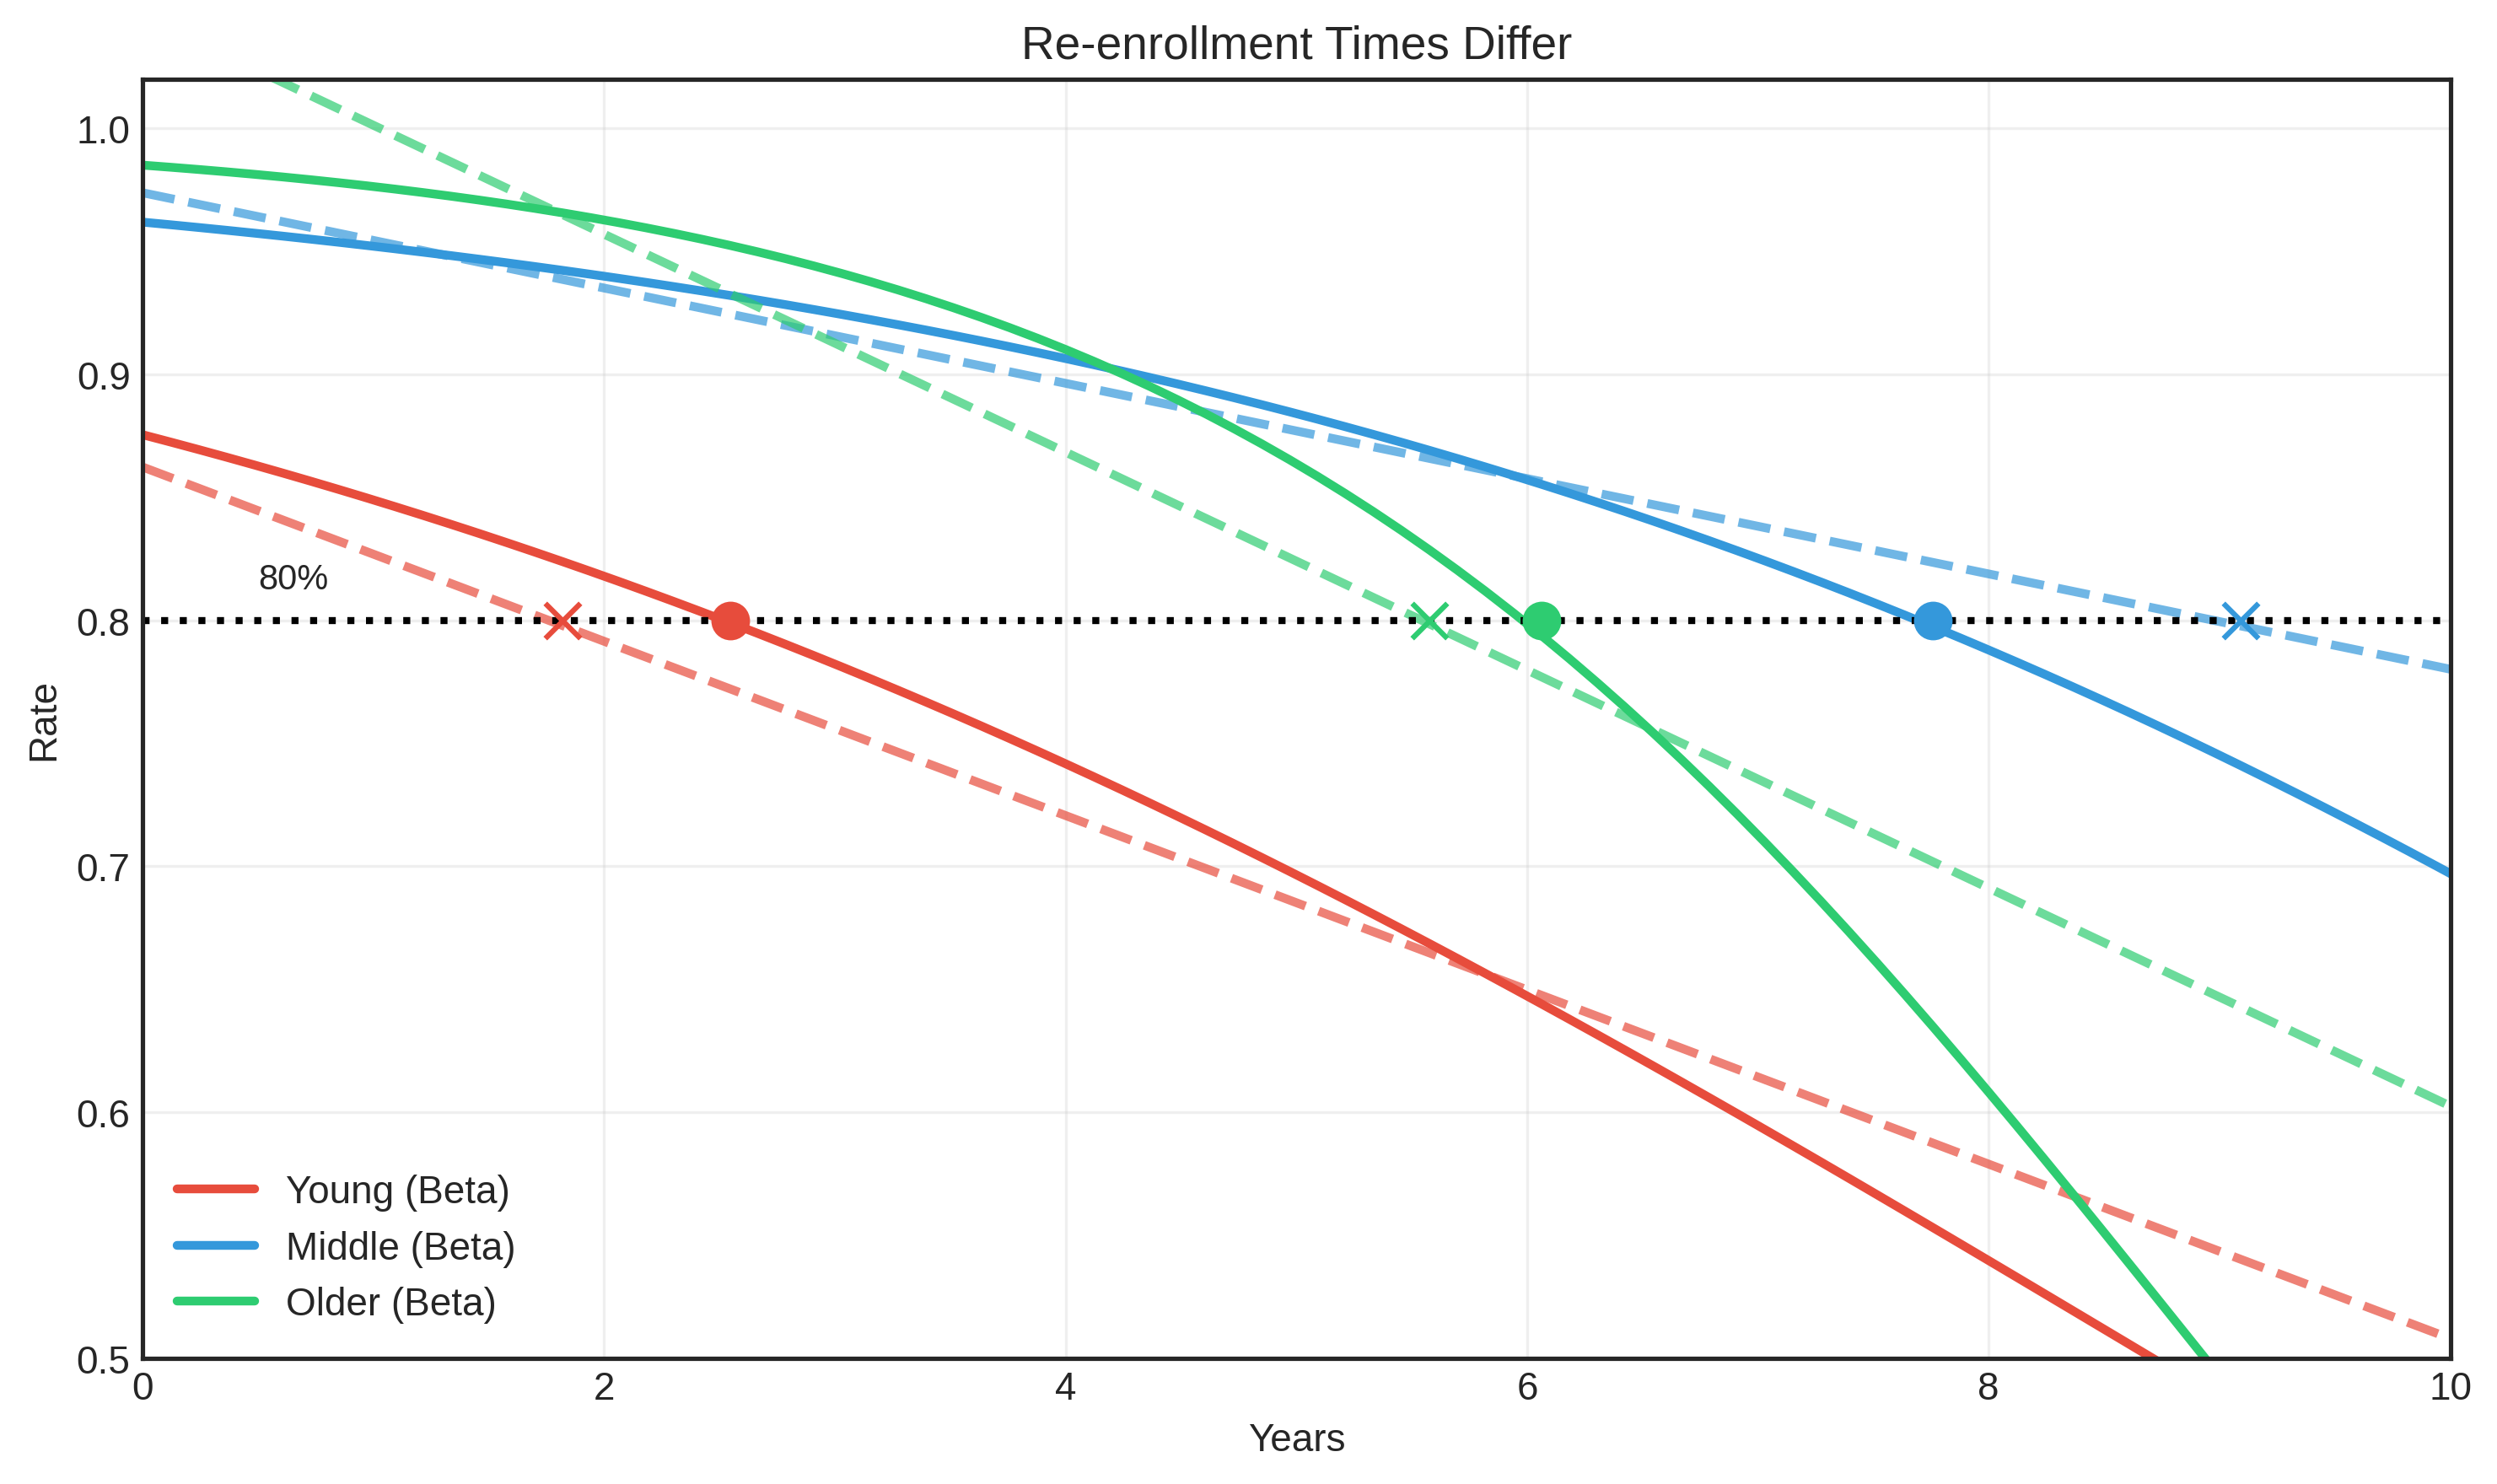

In [23]:
def analyze_operational_impact(pred_data, threshold=0.8):
    """Show operational differences."""
    fig, ax = plt.subplots(1, 1, figsize=(10, 6))

    results = []

    for age_group in ['young', 'middle', 'older']:
        group_pred = pred_data[pred_data['age_group'] == age_group]

        # Draw
        ax.plot(group_pred['time'], group_pred['beta_pred'],
                color=COLORS[age_group], linewidth=2.5,
                label=f'{age_group.capitalize()} (Beta)')
        ax.plot(group_pred['time'], group_pred['lmm_pred'],
                color=COLORS[age_group], linewidth=2.5, linestyle='--', alpha=0.7)

        # Find cross
        beta_cross = group_pred[group_pred['beta_pred'] < threshold]['time'].min()
        lmm_cross = group_pred[group_pred['lmm_pred'] < threshold]['time'].min()

        # Mark
        if not np.isnan(beta_cross):
            ax.scatter(beta_cross, threshold, color=COLORS[age_group],
                      s=100, marker='o', zorder=5)
        if not np.isnan(lmm_cross):
            ax.scatter(lmm_cross, threshold, color=COLORS[age_group],
                      s=100, marker='x', zorder=5)

        # Save
        beta_time = f'{beta_cross:.1f}' if not np.isnan(beta_cross) else '>12'
        lmm_time = f'{lmm_cross:.1f}' if not np.isnan(lmm_cross) else '>12'
        diff = f'{abs(beta_cross - lmm_cross):.1f}' if not (np.isnan(beta_cross) or np.isnan(lmm_cross)) else 'N/A'

        results.append({
            'Group': age_group.capitalize(),
            'Linear': lmm_time,
            'Beta': beta_time,
            'Diff': diff
        })

    # Line
    ax.axhline(y=threshold, color='black', linestyle=':', linewidth=2)
    ax.text(0.5, threshold + 0.01, '80%', ha='left', va='bottom', fontsize=10)

    # Format
    ax.set_xlabel('Years')
    ax.set_ylabel('Rate')
    ax.set_title('Re-enrollment Times Differ')
    ax.set_ylim(0.5, 1.02)
    ax.set_xlim(0, 10)
    ax.legend(loc='lower left')
    ax.grid(True, alpha=0.3)

    plt.tight_layout()

    # Show
    results_df = pd.DataFrame(results)
    print("\nRe-enrollment (years)")
    print("-" * 35)
    print(results_df.to_string(index=False))

    return fig

fig5 = analyze_operational_impact(pred_data)
plt.show()

## 12. Summary

In [24]:
def generate_summary_statistics(data):
    """Make summary."""
    summary = []

    for age_group in ['young', 'middle', 'older']:
        group_data = data[data['age_group'] == age_group]

        # Stats
        subject_stats = group_data.groupby('subject_id')['recognition_rate'].agg(['first', 'last', 'count'])

        initial = subject_stats['first'].mean()
        final = subject_stats['last'].mean()

        summary.append({
            'Group': age_group.capitalize(),
            'Ages': {'young': '3-5', 'middle': '5.5-7', 'older': '7.5-9'}[age_group],
            'N': len(subject_stats),
            'Obs': f"{subject_stats['count'].mean():.1f}",
            'Start': f"{initial:.1%}",
            'End': f"{final:.1%}",
            'Drop': f"{initial - final:.1%}"
        })

    summary_df = pd.DataFrame(summary)

    print("\nData")
    print("-" * 55)
    print(summary_df.to_string(index=False))

    return summary_df

summary_table = generate_summary_statistics(full_data)


Data
-------------------------------------------------------
 Group  Ages   N  Obs Start   End  Drop
 Young   3-5 100 15.4 96.6% 63.1% 33.5%
Middle 5.5-7 100 15.3 96.9% 81.9% 15.0%
 Older 7.5-9 100 15.3 97.8% 62.7% 35.1%


## 13. Key Results

Beta regression beats linear models three ways.

**Bounds work.** Linear models break. Older children exceed 100% at start. Young children go negative at 9 years. Beta models stay valid.

**Variance works.** Variance peaks at 50% recognition (0.0049). Near 0% and 100%, variance drops (0.0008). Linear models use constant variance (0.0043). Beta models match reality.

**Decisions improve.** Young children gain 8 months before re-enrollment. Middle children lose 16 months. Older children gain 6 months. These changes affect missing child searches.

Both models fit similarly (RMSE near 0.065). But beta models work for long predictions. Linear models fail after the data ends.

In [25]:
# Save
print("\nSaving...")
fig1.savefig('age_patterns.pdf', dpi=300, bbox_inches='tight')
fig2.savefig('boundary_violations.pdf', dpi=300, bbox_inches='tight')
fig3.savefig('variance_analysis.pdf', dpi=300, bbox_inches='tight')
fig4.savefig('prediction_intervals.pdf', dpi=300, bbox_inches='tight')
fig5.savefig('operational_impact.pdf', dpi=300, bbox_inches='tight')
print("Done.")


Saving...
Done.


## Conclusion

Use beta regression for bounded data. The model respects limits. It captures variance correctly. It improves decisions. The code changes little but gains are large.